# Proceedings classification

We have combined a pre-trained Word2Vec, RNN and CNN for classification.

## Setup

In [1]:
%env PYTHONHASHSEED=0

env: PYTHONHASHSEED=0


In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES']=""
os.environ['TF_CUDNN_USE_AUTOTUNE'] ='0'

if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

In [3]:
import numpy as np
import random 
random_seed=9
random.seed(random_seed)
np.random.seed(random_seed)

import tensorflow as tf
from tensorflow import set_random_seed
set_random_seed(random_seed)

from keras import backend as K
config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1) #,allow_soft_placement=True, device_count = {'CPU': 1})
sess = tf.Session(graph=tf.get_default_graph(),config=config)
K.set_session(sess)

Using TensorFlow backend.


In [4]:
import random
import pandas as pd
import numpy as np
import re
import pickle
import unidecode
import time
import matplotlib.pyplot as plt
import seaborn as sns
import copy 
from random import choice
import time

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.similarities.index import AnnoyIndexer
from gensim.models.phrases import Phrases, Phraser
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

import keras
from keras.models import Model, load_model, Sequential
from keras import optimizers, regularizers
from keras.regularizers import l1,  l2
from keras.layers import Input, Flatten,RNN,LSTM,GRU, Conv1D,Dense, TimeDistributed,GlobalMaxPooling1D, Lambda
from keras.constraints import unit_norm

from itertools import product
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/maiapolo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preparing

Opening Word2Vec pre-trained model:

In [5]:
word = KeyedVectors.load("modelos/doc2vec_mov_100_5_V5")

In [6]:
embed_dim=np.shape(word['juiz'])[0]
embed_dim

100

Our vocabulary:

In [7]:
word_vectors = word.wv

Stopwords:

In [8]:
stop_words = set(stopwords.words('portuguese')) 

Function for embedding (normalized):

In [9]:
def emb(s):
    return(word[s]/np.sqrt(word[s]@word[s]))

## Preparing dataset

In [10]:
with open("bases/mov.txt", "rb") as fp:   # Legal proceedings
    mov = pickle.load(fp)

with open("bases/tags.txt", "rb") as fp:   # Tags
    tags = pickle.load(fp)

Opening models that identify combinations of words as unique tokens:

In [11]:
bigrams=Phrases.load('modelos/bigrams_mov')
bibigrams=Phrases.load('modelos/bibigrams_mov')

Letting motions in cronological order:

In [12]:
mov[0][:4]

[['14-11-2018',
  'Tipo do Movimento:Ato Ordinatório Praticado Descrição:Certifico e dou fé que as custas pendentes de fls 685 não foram recolhidas pelas parte GILMAR RODRIGUES REGO e BRUNO MEDEIROS.'],
 ['23-07-2018',
  'Tipo do Movimento:Juntada - Petição Descrição da juntada:Documento eletrônico juntado de forma automática.'],
 ['16-07-2018',
  'Tipo do Movimento:Publicado\xa0 Atos da Serventia Folhas do DJERJ.:388/416'],
 ['29-06-2018', 'Tipo do Movimento:Enviado para publicação ']]

In [13]:
for m in mov:
    m.reverse()

In [14]:
mov[0][:4]

[['10-09-2010',
  'Tipo do Movimento:Distribuição Sorteio Serventia:Cartório da 34ª Vara Cível - 34ª Vara Cível'],
 ['21-09-2010',
  'Tipo do Movimento:Conclusão ao Juiz Juiz:JOAO MARCOS DE CASTELLO BRANCO FANTINATO'],
 ['23-09-2010',
  'Tipo do Movimento:Despacho - Proferido despacho de mero expediente Descrição:Defiro JG. \r\n\r\nIndefiro a antecipação dos efeitos da tutela, eis que as alegações do autor carecem de dilação probatória.\r\n\r\nCite-se.'],
 ['23-09-2010', 'Tipo do Movimento:Enviado para publicação ']]

Defining functions we will use:

In [15]:
#Function that cleans texts:
def clean(resulta):   
    import copy 
   
    result = copy.deepcopy(resulta)
    
    result=result.lower()
    result=re.sub('\d', ' ', result)
    result=result.replace("lei ", "lei_")
    result=result.replace("lei nº ", "lei_")
    result=result.replace("lei n.º" ,"lei_")
    result=result.replace("lei estadual nº ", "lei_") 
    result=result.replace("lei federal nº ", "lei_") 
    result=result.replace("lei municipal nº ", "lei_")
    result=result.replace("fl. ", "fls. ")
    result=result.replace("fls. ", "fls_") 
    result=result.replace("p. ", "pp. ")
    result=result.replace("pp. ", "pp_")
    result=result.replace("art. ", "art_") 
    result=result.replace("artigo ", "art_")
    result=result.replace("inciso ", "inciso_") 
    result=result.replace("nº ", "nº_")
    result=result.replace("n° ", "nº_")
    result=result.replace("º ", "º")
    result=result.replace("ª ", "ª")
    result=result.replace("oab ", "oab_")
    result=result.replace("r$ ", "r$_")
    result=result.replace("\n", " ")
    result=result.replace("dr ", "dr_")
    result=result.replace("dr. ", "dr_")
    result=result.replace("dra ", "dr_")
    result=result.replace("dra. ", "dr_")
    result=result.replace("adv: ", "adv_") 
    
    result=result.replace("/", " ")
    result=result.replace("|", " ")
    result=result.replace("+", " ")
    result=result.replace(".", " ")
    result=result.replace(",", " ")
    result=result.replace(":", " ")
    result=result.replace(";", " ")
    result=result.replace("!", " ")
    result=result.replace("?", " ")
    result=result.replace(">", " ")
    result=result.replace("=", " ")
    result=result.replace("§", " ")
    result=result.replace(" - ", " ")
    result=result.replace(" _ ", " ")
    result=result.replace("&", " ")
    result=result.replace("*", " ")
    result=result.replace("(", " ")
    result=result.replace(")", " ")
    result=result.replace("ª", " ")
    result=result.replace("º", " ")
    result=result.replace("%", " ")
    result=result.replace("[", " ")
    result=result.replace("]", " ")
    result=result.replace("{", " ")
    result=result.replace("}", " ")
    result=result.replace("'", " ")
    result=result.replace('"', " ")
    result=result.replace("“", " ")
    result=result.replace("”", " ")
    result=re.sub(' +', ' ', result)

    return(result)

In [16]:
#Tokenizer
stop_words = set(stopwords.words('portuguese'))

def tokenize(txt):
    texto=unidecode.unidecode(txt) #decodificando
    texto=clean(texto) #limpando texto
    texto=texto.split(' ') 
    
    tokens=[]
    for t in texto:
        if t not in stop_words: tokens.append(t)
        else: pass
        
    tokens=bibigrams[bigrams[tokens]]
 
    return(tokens)

In [17]:
#Transform a sequence of tokens to the matrix form, 
#where each line is given by an embedded token
def tokens2matrix(tokens):
    matrix=[]
    for s in tokens: 
        if (s in word_vectors.vocab) and (s not in stop_words): #in vocab and no stopwords
            matrix.append(list(emb(s)))
        else: pass
    return(np.array(matrix))

In [18]:
#function that checks if in a given text there is at least one word in the vocabulary
def in_vocab(texto):
    for s in tokenize(texto):
        if (s in word_vectors.vocab) and (s not in stop_words): return(True)
        else: pass
    return(False)

Let's evaluate the distribution of motion quantities per proceeding.

In [19]:
leng1=[]
for i in range(len(mov)):
    leng1.append(len(mov[i]))

In [20]:
dist1=[]
leng1=np.array(leng1)

for i in range(300):
    dist1.append([i,np.mean(leng1<=i)])
    
dist1=np.array(dist1)

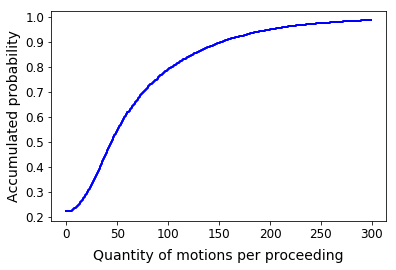

In [21]:
plt.step(dist1[:,0],dist1[:,1],color='blue', linewidth=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Accumulated probability', size=14)
plt.xlabel('Quantity of motions per proceeding', fontsize=14, labelpad=8)
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("plots/dist_mov.png", facecolor='white', dpi=100)
plt.show()

Let's evaluate the distribution of tokens quantities per motion.

In [ ]:
leng=[]
for i in range(len(mov)):
    for j in range(len(mov[i])):
        leng.append(np.shape(tokens2matrix(tokenize(mov[i][j][1])))[0])

In [ ]:
dist=[]
leng=np.array(leng)

for i in range(75):
    dist.append([i,np.mean(leng<=i)])
    
dist=np.array(dist)

In [ ]:
plt.step(dist[:,0],dist[:,1],color='blue', linewidth=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Accumulated probability', fontsize=14)
plt.xlabel('Quantity of tokens per motion', fontsize=14, labelpad=8)
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("plots/dist_token.png", facecolor='white', dpi=100)
plt.show()

You can see that over 90% of motions have 30 tokens or less. In our application we will keep the first 30 tokens of each move.

Defining function that will help us get the X and y bases used for learning.

In [22]:
def get_X_y_cnn(mov,tags,len1=5,len2=30):
    
    #len1: let's take the last len1 motions in each proceeding
    #len2: let's take the first len2 tokens in each motion
    
    #indexes of valid legal proceedings (with motions and tags)
    index=[]
    for i in range(len(mov)):
        if 0<len(mov[i]) and tags[i]!="": index.append(i) 
        else: pass

    print("Number of valid proceedings (with motions and tags):",len(index),"\n")

    #organizing motions in X and tags in y
    X=np.zeros((len(index),len1,len2,embed_dim))
    y=[]
    cont=0
    
    #get numerical X embedding the tokens from those motions (from valid proceedings):
    for i in index:
        temp=[]
        y.append(tags[i])

        mov[i]=mov[i][-len1::] #let's take the last len1 motions in each proceeding

        for j in range(len(mov[i])):

            if in_vocab(mov[i][j][1]):  #if there is at least one word in the vocabulary
                temp=tokens2matrix(tokenize(mov[i][j][1])[:len2]) #let's take the first len2 tokens in each motion and turn them into a matrix l2x100
                X[cont][j][:np.shape(temp)[0]]=temp
            else: pass


        #counter
        cont+=1
        if cont%int(len(index)/5)==0: print(round(100*cont/len(index),0),"% concluded")
        else: pass
        
    return X,y

In [23]:
len1=5 #vamos pegar somente as últimas len1 movimentações
len2=30 #vamos pegar somente os primeiros len2 tokens de cada movimentação

X,y=get_X_y_cnn(mov,tags,len1,len2)

Number of valid proceedings (with motions and tags): 6449 

20.0 % concluded
40.0 % concluded
60.0 % concluded
80.0 % concluded
100.0 % concluded


Y Distribution

In [24]:
print('H:Arquivado',np.sum(np.array(y)=='H:Arquivado'),np.mean(np.array(y)=='H:Arquivado'), '\n')
print('H:Ativo',np.sum(np.array(y)=='H:Ativo'),np.mean(np.array(y)=='H:Ativo'), '\n')
print('H:Suspenso',np.sum(np.array(y)=='H:Suspenso'),np.mean(np.array(y)=='H:Suspenso'), '\n')

H:Arquivado 3040 0.4713909133198946 

H:Ativo 2917 0.45231818886649094 

H:Suspenso 492 0.07629089781361452 



Latex table of Y distribution:

In [25]:
print("\\begin{table}[H] \n",
      "\centering \n",
      "\caption{Distribution of legal proceedings' labels} \n",
      ' \\begin{tabular}{c|c|c} \n',
      ' \\toprule \n',
      '        & \% & N\\\ \n',
      ' \midrule \n',
      ' Archived (class 1) &'+str(np.round(100*np.mean(np.array(y)=='H:Arquivado'),2))+'\%'+' & '+str(np.sum(np.array(y)=='H:Arquivado'))+'\\\ \n',
      ' Active (class 2) &'+str(np.round(100*np.mean(np.array(y)=='H:Ativo'),2))+'\%'+' & '+str(np.sum(np.array(y)=='H:Ativo'))+'\\\ \n',
      ' Suspended (class 3) &'+str(np.round(100*np.mean(np.array(y)=='H:Suspenso'),2))+'\%'+' & '+str(np.sum(np.array(y)=='H:Suspenso'))+'\\\ \n',
      ' \midrule \n',
      ' Total &'+str(100)+'\%'+' & '+str(len(y))+'\\\ \n',
      ' \\bottomrule \n',
      ' \end{tabular}% \n',
      '\label{tab:lab}% \n',
   '\end{table}% \n')

\begin{table}[H] 
 \centering 
 \caption{Distribution of legal proceedings' labels} 
  \begin{tabular}{c|c|c} 
  \toprule 
         & \% & N\\ 
  \midrule 
  Archived (class 1) &47.14\% & 3040\\ 
  Active (class 2) &45.23\% & 2917\\ 
  Suspended (class 3) &7.63\% & 492\\ 
  \midrule 
  Total &100\% & 6449\\ 
  \bottomrule 
  \end{tabular}% 
 \label{tab:lab}% 
 \end{table}% 



Turning y into numeric:

In [26]:
encode={'H:Arquivado': 1,'H:Ativo': 2,'H:Suspenso': 3}
decode={1:'H:Arquivado',2:'H:Ativo',3:'H:Suspenso'}
#
for i in range(len(y)):
    y[i]=encode[y[i]]

Splitting the dataset in train, test and validation set:

In [27]:
y=np.array(y)
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=2/3, random_state=22)
#
y_train2=np.array(pd.get_dummies(y_train))
y_val2=np.array(pd.get_dummies(y_val))
y_test2=np.array(pd.get_dummies(y_test))

np.shape(X_train),np.shape(y_train)

((4514, 5, 30, 100), (4514,))

In [28]:
n_train=len(y_train)
n_val=len(y_val)
n_test=len(y_test)
n=n_train+n_val+n_test

print("\\begin{table}[H] \n",
      "\centering \n",
      "\caption{Training, validation and test sets} \n",
      ' \\begin{tabular}{c|c|c} \n',
      ' \\toprule \n',
      '        & \% & N\\\ \n',
      ' \midrule \n',
      ' Training set &'+str(np.round(100*(n_train/n),2))+'\%'+' & '+str(n_train)+'\\\ \n',
      ' Validation set &'+str(np.round(100*(n_val/n),2))+'\%'+' & '+str(n_val)+'\\\ \n',
      ' Test set &'+str(np.round(100*(n_test/n),2))+'\%'+' & '+str(n_test)+'\\\ \n',
      ' \midrule \n',
      ' Total &'+str(100)+'\%'+' & '+str(len(y))+'\\\ \n',
      ' \\bottomrule \n',
      ' \end{tabular}% \n',
      '\label{tab:lab}% \n',
   '\end{table}% \n')    

\begin{table}[H] 
 \centering 
 \caption{Training, validation and test sets} 
  \begin{tabular}{c|c|c} 
  \toprule 
         & \% & N\\ 
  \midrule 
  Training set &70.0\% & 4514\\ 
  Validation set &10.0\% & 645\\ 
  Test set &20.0\% & 1290\\ 
  \midrule 
  Total &100\% & 6449\\ 
  \bottomrule 
  \end{tabular}% 
 \label{tab:lab}% 
 \end{table}% 



### Running classification model

Training final model:

In [29]:
keras.backend.clear_session()
random.seed(9)
np.random.seed(9)
tf.set_random_seed(9)

k=12 #Number of CNN filters (kernels)
num_classes = 3
neuron=10
Adam=keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, amsgrad=False)

### model for features extraction
inputs = Input(shape=np.shape(X_train)[1:])
conv = TimeDistributed(Conv1D(k, 1, activation='relu',kernel_constraint=unit_norm(axis=1), use_bias=False))(inputs)
pool = TimeDistributed(GlobalMaxPooling1D())(conv)
#
model_feat = Model(inputs, pool)
model_feat.summary()
print('\n')

### model for classification
pooled_inputs = Input(shape=(5, k))
lstm = LSTM(neuron, kernel_regularizer=l1(.0001))(pooled_inputs)
soft = Dense(num_classes, activation='softmax')(lstm)
#
model_classific = Model(pooled_inputs, soft)
model_classific.summary()
print('\n')

### final model
outputs = model_classific(model_feat(inputs))
model_cnn = Model(inputs, outputs)
model_cnn.summary()

#compiling
model_cnn.compile(loss='categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])

#fitting
modelo=model_cnn.fit(X_train, y_train2, epochs=50,
                                          batch_size=500,
                                          shuffle=True,
                                          verbose=False,
                                          validation_data=(X_val, y_val2))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 30, 100)        0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 30, 12)         1200      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 12)             0         
Total params: 1,200
Trainable params: 1,200
Non-trainable params: 0
_________________________________________________________________


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5, 12)             0         
_________________________________________________________________
lstm_1 (LSTM)          

Saving neural network weights:

In [30]:
model_cnn.save('modelos/model_paper_status.h5') 
model_feat.save('modelos/model_feat_paper_status.h5') 
model_classific.save('modelos/model_classific_paper_status.h5') 

### Model evaluation

Accuracy plotting:

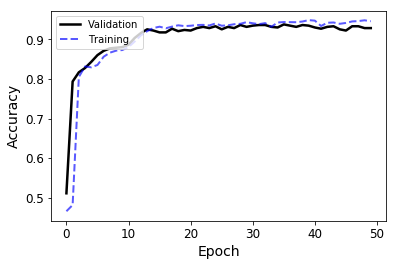

In [31]:
#Plotando dados de treino
plt.plot(modelo.history['val_accuracy'], 'k-', linewidth=2.5)
plt.plot(modelo.history['accuracy'],'b--', linewidth=2, alpha=.65)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(['Validation', 'Training'], loc='upper left')
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("plots/acuracia.png", facecolor='white', dpi=100)
plt.show()

Accuracy and confusion matrix in test set

Accuracy test set=0.93 +- 0.01 

0.9137926536291378 0.9420212998592344


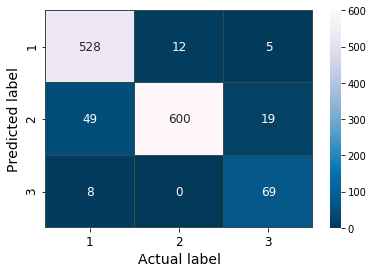

In [32]:
#Accuracy
probs_y=model_cnn.predict(X_test)
y_pred=np.argmax(probs_y,axis=1)
y_real=np.argmax(y_test2,axis=1)
p=np.mean(y_pred==y_real)

dict_acc={}
dict_acc['cnn']=[np.round(p,2), np.round(1.96*np.sqrt((p*(1-p)/np.shape(y_pred)[0])),2)]

print("Accuracy test set=%3.2f" % p ,"+-", np.round(1.96*np.sqrt((p*(1-p)/np.shape(y_pred)[0])),2), "\n")
print(p-1.96*np.sqrt((p*(1-p)/np.shape(y_pred)[0])),p+1.96*np.sqrt((p*(1-p)/np.shape(y_pred)[0])))

#Matrix
x_axis_labels = ['1', '2', '3'] # labels for x-axis
y_axis_labels = [1,2,3] # labels for y-axis

conf=confusion_matrix(y_pred,y_real) #/np.sum(confusion_matrix(y_pred,y_real))
ax = sns.heatmap(conf, annot=True, linecolor='darkslategrey', fmt="g", xticklabels=x_axis_labels, yticklabels=y_axis_labels,
                 annot_kws={"fontsize":12}, linewidths=.1, cmap="PuBu_r") #fmt=".2%", , cmap="Greys" 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Predicted label', size=14)
plt.xlabel('Actual label', size=14)
plt.savefig("plots/conf.png", facecolor='white', dpi=300)
plt.show()

##### Metrics by class:

In [33]:
report=classification_report(y_real, y_pred, labels=[0, 1, 2], output_dict=True)

In [34]:
def CI(report, conf):

    conf=confusion_matrix(y_pred,y_real)
    report=classification_report(y_real, y_pred, labels=[0, 1, 2], output_dict=True)
    
    ####################################### BY CLASS #######################################
    ##### PRECISION #####
    n=np.sum(conf,axis=1)

    ### Class 0 ###
    c=0
    p_prec_0=conf[c,c]/n[c]

    # Bootstrap #
    samp=np.hstack((np.ones(conf[c,c]), np.zeros(n[c]-conf[c,c])))
    dist_prec_0=[np.mean(np.random.choice(samp, n[c])) for i in range(10000)]
    er_prec_0=np.round(((np.mean(dist_prec_0)-np.percentile(dist_prec_0, 2.5))+(np.percentile(dist_prec_0, 97.5)-np.mean(dist_prec_0)))/2,2)


    ### Class 1 ###
    c=1
    p_prec_1=conf[c,c]/n[c]

    # Bootstrap #
    samp=np.hstack((np.ones(conf[c,c]), np.zeros(n[c]-conf[c,c])))
    dist_prec_1=[np.mean(np.random.choice(samp, n[c])) for i in range(10000)]
    er_prec_1=np.round(((np.mean(dist_prec_1)-np.percentile(dist_prec_1, 2.5))+(np.percentile(dist_prec_1, 97.5)-np.mean(dist_prec_1)))/2,2)


    ### Class 2 ###
    c=2
    p_prec_2=conf[c,c]/n[c]

    # Bootstrap #
    samp=np.hstack((np.ones(conf[c,c]), np.zeros(n[c]-conf[c,c])))
    dist_prec_2=[np.mean(np.random.choice(samp, n[c])) for i in range(10000)]
    er_prec_2=np.round(((np.mean(dist_prec_2)-np.percentile(dist_prec_2, 2.5))+(np.percentile(dist_prec_2, 97.5)-np.mean(dist_prec_2)))/2,2)


    ##### RECALL #####
    n=np.sum(conf,axis=0)

    ### Class 0 ###
    c=0
    p_rec_0=conf[c,c]/n[c]

    # Bootstrap #
    samp=np.hstack((np.ones(conf[c,c]), np.zeros(n[c]-conf[c,c])))
    dist_rec_0=[np.mean(np.random.choice(samp, n[c])) for i in range(10000)]
    er_rec_0=np.round(((np.mean(dist_rec_0)-np.percentile(dist_rec_0, 2.5))+(np.percentile(dist_rec_0, 97.5)-np.mean(dist_rec_0)))/2,2)


    ### Class 1 ###
    c=1
    p_rec_1=conf[c,c]/n[c]

    # Bootstrap #
    samp=np.hstack((np.ones(conf[c,c]), np.zeros(n[c]-conf[c,c])))
    dist_rec_1=[np.mean(np.random.choice(samp, n[c])) for i in range(10000)]
    er_rec_1=np.round(((np.mean(dist_rec_1)-np.percentile(dist_rec_1, 2.5))+(np.percentile(dist_rec_1, 97.5)-np.mean(dist_rec_1)))/2,2)


    ### Class 2 ###
    c=2
    p_rec_2=conf[c,c]/n[c]

    # Bootstrap #
    samp=np.hstack((np.ones(conf[c,c]), np.zeros(n[c]-conf[c,c])))
    dist_rec_2=[np.mean(np.random.choice(samp, n[c])) for i in range(10000)]
    er_rec_2=np.round(((np.mean(dist_rec_2)-np.percentile(dist_rec_2, 2.5))+(np.percentile(dist_rec_2, 97.5)-np.mean(dist_rec_2)))/2,2)


    ##### F1 #####
    def f1(prec, rec):
        return(2*(prec*rec)/(prec+rec))

    ### Class 0 ###
    dist_f1_0=f1(np.array(dist_prec_0), np.array(dist_rec_0))
    er_f1_0=np.round(((np.mean(dist_f1_0)-np.percentile(dist_f1_0, 2.5))+(np.percentile(dist_f1_0, 97.5)-np.mean(dist_f1_0)))/2,2)

    ### Class 1 ###
    dist_f1_1=f1(np.array(dist_prec_1), np.array(dist_rec_1))
    er_f1_1=np.round(((np.mean(dist_f1_1)-np.percentile(dist_f1_1, 2.5))+(np.percentile(dist_f1_1, 97.5)-np.mean(dist_f1_1)))/2,2)

    ### Class 2 ###
    dist_f1_2=f1(np.array(dist_prec_2), np.array(dist_rec_2))
    er_f1_2=np.round(((np.mean(dist_f1_2)-np.percentile(dist_f1_2, 2.5))+(np.percentile(dist_f1_2, 97.5)-np.mean(dist_f1_2)))/2,2)


    ####################################### AGGREGATE #######################################

    ##### PRECISION #####
    n=np.sum(conf,axis=0)

    ### Macro ###
    dist_prec_macro=(np.array(dist_prec_0)+np.array(dist_prec_1)+np.array(dist_prec_2))/3
    er_prec_macro=np.round(((np.mean(dist_prec_macro)-np.percentile(dist_prec_macro, 2.5))+(np.percentile(dist_prec_macro, 97.5)-np.mean(dist_prec_macro)))/2,2)

    ### Micro ###
    dist_prec_micro=(np.array(dist_prec_0)*n[0]+np.array(dist_prec_1)*n[1]+np.array(dist_prec_2)*n[2])/np.sum(n)
    er_prec_micro=np.round(((np.mean(dist_prec_micro)-np.percentile(dist_prec_micro, 2.5))+(np.percentile(dist_prec_micro, 97.5)-np.mean(dist_prec_micro)))/2,2)


    ##### RECALL #####
    n=np.sum(conf,axis=0)

    ### Macro ###
    dist_rec_macro=(np.array(dist_rec_0)+np.array(dist_rec_1)+np.array(dist_rec_2))/3
    er_rec_macro=np.round(((np.mean(dist_rec_macro)-np.percentile(dist_rec_macro, 2.5))+(np.percentile(dist_rec_macro, 97.5)-np.mean(dist_rec_macro)))/2,2)

    ### Micro ###
    dist_rec_micro=(np.array(dist_rec_0)*n[0]+np.array(dist_rec_1)*n[1]+np.array(dist_rec_2)*n[2])/np.sum(n)
    er_rec_micro=np.round(((np.mean(dist_rec_micro)-np.percentile(dist_rec_micro, 2.5))+(np.percentile(dist_rec_micro, 97.5)-np.mean(dist_rec_micro)))/2,2)


    ##### F1 #####
    n=np.sum(conf,axis=0)

    ### Macro ###
    dist_f1_macro=(np.array(dist_f1_0)+np.array(dist_f1_1)+np.array(dist_f1_2))/3
    er_f1_macro=np.round(((np.mean(dist_f1_macro)-np.percentile(dist_f1_macro, 2.5))+(np.percentile(dist_f1_macro, 97.5)-np.mean(dist_f1_macro)))/2,2)

    ### Micro ###
    dist_f1_micro=(np.array(dist_f1_0)*n[0]+np.array(dist_f1_1)*n[1]+np.array(dist_f1_2)*n[2])/np.sum(n)
    er_f1_micro=np.round(((np.mean(dist_f1_micro)-np.percentile(dist_f1_micro, 2.5))+(np.percentile(dist_f1_micro, 97.5)-np.mean(dist_f1_micro)))/2,2)
    
    ####################################### OUTPUT #######################################
    
    #BY CLASS
    lista=[]
    for i in range(num_classes):
        lista.append([np.round(report[str(i)]['f1-score'],2),np.round(report[str(i)]['precision'],2),np.round(report[str(i)]['recall'],2),np.round(report[str(i)]['support'],2)])
    
    dict_class={}
    
    dict_class['class1']={}
    dict_class['class1']['f1']=[lista[0][0],er_f1_0]
    dict_class['class1']['prec']=[lista[0][1],er_prec_0]
    dict_class['class1']['rec']=[lista[0][2],er_rec_0]
    dict_class['class1']['N']=[lista[0][3]]
    
    dict_class['class2']={}
    dict_class['class2']['f1']=[lista[1][0],er_f1_1]
    dict_class['class2']['prec']=[lista[1][1],er_prec_1]
    dict_class['class2']['rec']=[lista[1][2],er_rec_1]
    dict_class['class2']['N']=[lista[1][3]]
    
    dict_class['class3']={}
    dict_class['class3']['f1']=[lista[2][0],er_f1_2]
    dict_class['class3']['prec']=[lista[2][1],er_prec_2]
    dict_class['class3']['rec']=[lista[2][2],er_rec_2]
    dict_class['class3']['N']=[lista[2][3]]
    

    #AGGREGATE
    lista=[]
    for i in ['macro avg','weighted avg']:
        lista.append([np.round(report[str(i)]['f1-score'],2),np.round(report[str(i)]['precision'],2),np.round(report[str(i)]['recall'],2),np.round(report[str(i)]['support'],2)])

    dict_agg={}
    
    dict_agg['macro']={}
    dict_agg['macro']['f1']=[lista[0][0],er_f1_macro]
    dict_agg['macro']['prec']=[lista[0][1],er_prec_macro]
    dict_agg['macro']['rec']=[lista[0][2],er_rec_macro]
    dict_agg['macro']['N']=[lista[0][3]]
    
    dict_agg['micro']={}
    dict_agg['micro']['f1']=[lista[1][0],er_f1_micro]
    dict_agg['micro']['prec']=[lista[1][1],er_prec_micro]
    dict_agg['micro']['rec']=[lista[1][2],er_rec_micro]
    dict_agg['micro']['N']=[lista[1][3]]
    
    return(dict_class, dict_agg)

In [35]:
dict_class_cnn, dict_agg_cnn=CI(report,conf)

Defining confidence interval for the three classes:

Latex table

In [36]:
print("\\begin{table}[H] \n",
      "\centering \n",
      '\caption{Evaluation metrics by class} \n',
      ' \\begin{tabular}{c|c|c|c|c} \n',
      ' \\toprule \n',
      '       & F1 Score & Precision & Recall & N\\\ \n',
      ' \midrule \n',
      ' Archived (class 1) &'+str(dict_class_cnn['class1']['f1'][0])+' \pm '+str(dict_class_cnn['class1']['f1'][1])+'&'+str(dict_class_cnn['class1']['prec'][0])+' \pm '+str(dict_class_cnn['class1']['prec'][1])+'&'+str(dict_class_cnn['class1']['rec'][0])+' \pm '+str(dict_class_cnn['class1']['rec'][1])+'&'+str(dict_class_cnn['class1']['N'][0])+'\\\ \n',
      ' Active (class 2)  &'+str(dict_class_cnn['class2']['f1'][0])+' \pm '+str(dict_class_cnn['class2']['f1'][1])+'&'+str(dict_class_cnn['class2']['prec'][0])+' \pm '+str(dict_class_cnn['class2']['prec'][1])+'&'+str(dict_class_cnn['class2']['rec'][0])+' \pm '+str(dict_class_cnn['class2']['rec'][1])+'&'+str(dict_class_cnn['class2']['N'][0])+'\\\ \n',
      ' Suspended (class 3)  &'+str(dict_class_cnn['class3']['f1'][0])+' \pm '+str(dict_class_cnn['class3']['f1'][1])+'&'+str(dict_class_cnn['class3']['prec'][0])+' \pm '+str(dict_class_cnn['class3']['prec'][1])+'&'+str(dict_class_cnn['class3']['rec'][0])+' \pm '+str(dict_class_cnn['class3']['rec'][1])+'&'+str(dict_class_cnn['class3']['N'][0])+'\\\ \n',
      ' \\bottomrule \n',
      ' \end{tabular}% \n',
      '\label{tab:lab}% \n',
   '\end{table}% \n')

\begin{table}[H] 
 \centering 
 \caption{Evaluation metrics by class} 
  \begin{tabular}{c|c|c|c|c} 
  \toprule 
        & F1 Score & Precision & Recall & N\\ 
  \midrule 
  Archived (class 1) &0.93 \pm 0.01&0.97 \pm 0.01&0.9 \pm 0.02&585\\ 
  Active (class 2)  &0.94 \pm 0.01&0.9 \pm 0.02&0.98 \pm 0.01&612\\ 
  Suspended (class 3)  &0.81 \pm 0.06&0.9 \pm 0.07&0.74 \pm 0.09&93\\ 
  \bottomrule 
  \end{tabular}% 
 \label{tab:lab}% 
 \end{table}% 



# Interpretability

### What are the filters looking for?

Grabbing filters weights:

In [37]:
w=model_cnn.layers[1].get_weights()
np.shape(w)

(1, 1, 100, 12)

Number of terms closest to the filters we're going to take from vocabulary:

In [41]:
n_w=3

Table:

In [42]:
for n in range(k):
    v=np.reshape(w[0][:,:,n],-1)

    print("%Filter",n+1,"\n")
    
    for i in word.wv.similar_by_vector(v,n_w):
         print(i[0].replace("_", " "),np.round(i[1],2))
    
    print("\n\n")

%Filter 1 

arquivado definitivamente 0.46
baixa definitiva 0.45
ficha memoria arquivada livro 0.42



%Filter 2 

                                   escrev 0.51
agravo instrumento interesses transindividuais 0.48
sao paulo escrevente      0.48



%Filter 3 

usuario sicoliveira 0.54
usuario mgcsilva 0.51
usuario mcgazineo 0.51



%Filter 4 

arquivado provisoriamente 0.47
sobrestado 0.42
processo desarquivado 0.42



%Filter 5 

originais 0.56
autos 0.52
apresentando 0.51



%Filter 6 

comarca itaquaquecetuba 0.42
wvpv 0.41
cartorio origem cumprida 0.4



%Filter 7 

agravo instrumento interesses transindividuais 0.45
nada barueri novembro 0.43
gleidson 0.42



%Filter 8 

baixa definitiva 0.45
arquivado definitivamente 0.44
baixa 0.39



%Filter 9 

proferida 0.47
certidao 0.43
liminares concedidas 0.42



%Filter 10 

juizados especiais 0.44
embargos opostos 0.41
ilegitimidade passiva nesse sentido 0.41



%Filter 11 

arquivado provisoriamente 0.55
feito permaneca 0.5
dias decorri

Latex table:

In [43]:
print('\\begin{table}[H] \n',
      '\centering \n',
      '\\begin{threeparttable} \n',
      '\caption{Similarity between most similar tokens and filters} \n',
        '\\begin{tabular}{c|c|c} \n',
        '\\toprule \n',
     '\multicolumn{1}{c|}{} & \multicolumn{1}{c|}{Tokens} & \multicolumn{1}{c}{Cosine similarity}\\\\ \n')

for n in range(k):
    print('\midrule')
    v=np.reshape(w[0][:,:,n],-1)
    print('\multicolumn{1}{c|}{\multirow{'+str(n_w)+'}[2]{*}{Filter '+str(n+1)+'}} &'+ "\ textit{".replace(" ", "")+word.wv.similar_by_vector(v,n_w)[0][0].replace("_", " ")+'} &'+ str(np.round(word.wv.similar_by_vector(v,n_w)[0][1],2)) +' \\\\')
    for j in range(n_w-1):
        print('\multicolumn{1}{c|}{} &'+ "\ textit{".replace(" ", "")+word.wv.similar_by_vector(v,n_w)[j+1][0].replace("_", " ")+'} &'+str(np.round(word.wv.similar_by_vector(v,n_w)[j+1][1],2))+' \\\\')


print('\n \\bottomrule \n',
        '\end{tabular} \n',
      '\label{tab:simil} \n',
     '\end{threeparttable} \n',
    '\end{table} \n')

\begin{table}[H] 
 \centering 
 \begin{threeparttable} 
 \caption{Similarity between most similar tokens and filters} 
 \begin{tabular}{c|c|c} 
 \toprule 
 \multicolumn{1}{c|}{} & \multicolumn{1}{c|}{Tokens} & \multicolumn{1}{c}{Cosine similarity}\\ 

\midrule
\multicolumn{1}{c|}{\multirow{3}[2]{*}{Filter 1}} &\textit{arquivado definitivamente} &0.46 \\
\multicolumn{1}{c|}{} &\textit{baixa definitiva} &0.45 \\
\multicolumn{1}{c|}{} &\textit{ficha memoria arquivada livro} &0.42 \\
\midrule
\multicolumn{1}{c|}{\multirow{3}[2]{*}{Filter 2}} &\textit{                                   escrev} &0.51 \\
\multicolumn{1}{c|}{} &\textit{agravo instrumento interesses transindividuais} &0.48 \\
\multicolumn{1}{c|}{} &\textit{sao paulo escrevente     } &0.48 \\
\midrule
\multicolumn{1}{c|}{\multirow{3}[2]{*}{Filter 3}} &\textit{usuario sicoliveira} &0.54 \\
\multicolumn{1}{c|}{} &\textit{usuario mgcsilva} &0.51 \\
\multicolumn{1}{c|}{} &\textit{usuario mcgazineo} &0.51 \\
\midrule
\multicolumn{1}{

### How do features extracted by each filter relate to classification?

X-axis range

In [37]:
rang=np.arange(0, .6, 0.01).tolist()

Extracting CNN features

In [38]:
X_test_feat=model_feat.predict(X_test)

np.shape(X_test_feat)

(1290, 5, 12)

Calculating partial dependence functions

In [39]:
start_time = time.time()

kernels=list(range(k))
times=[0,1,2,3,4]

pdp={}
std={}

for kernel in kernels:
    
    pdp2={}
    std2={}
    
    for t in times:
        
        probs=[]
        stds=[]
        
        for i in rang:
            X_cf = copy.deepcopy(X_test_feat)
            X_cf[:,t, kernel]=i
            probs.append(np.mean(model_classific.predict(X_cf),axis=0).tolist())
            stds.append(np.std(model_classific.predict(X_cf),axis=0).tolist())
            
            
        pdp2[t]=np.array(probs)
        std2[t]=np.array(stds)
            
    pdp[kernel]=pdp2
    std[kernel]=std2

   
print((time.time() - start_time)/60,"minutos")

9.498579172293345 minutos


Centering the functions on zero

In [40]:
for kernel in kernels:
    for t in times:
            
        pdp[kernel][t]-=pdp[kernel][t][0,:]

Function that plot the functions

In [41]:
def pdp_plot2(kernel, target, legend=True, title=True, xaxis=True, yaxis=True, ytick=True, xtick=True, legend2=1):
    
    if xtick: xtick_size=16
    else: xtick_size=0
        
    if ytick: ytick_size=16
    else: ytick_size=0
        
    plt.plot(rang,pdp[kernel][0][:,target-1],'y:', linewidth=3,label='t = -5')
    plt.xticks(fontsize=xtick_size)
    plt.yticks(np.array([-.2,-.1,0,.1,.2]), fontsize=ytick_size)
    plt.plot(X_test_feat[:,0,kernel], [-.65+.4]*np.shape(X_test_feat)[0], '|', color='y', markersize=18)
    #er=1.96*std[kernel][0][:,target-1]/np.sqrt(np.shape(X_test_feat)[0])
    #plt.fill_between(rang, pdp[kernel][0][:,target-1]+er, pdp[kernel][0][:,target-1]-er, facecolor='yellow', alpha=.2)

    plt.plot(rang,pdp[kernel][1][:,target-1],'c--', linewidth=2,label='t = -4')
    plt.xticks(fontsize=xtick_size)
    plt.yticks(fontsize=ytick_size)
    plt.plot(X_test_feat[:,1,kernel], [-.66+.4]*np.shape(X_test_feat)[0], '|', color='c',  markersize=15)
    #er=1.96*std[kernel][1][:,target-1]/np.sqrt(np.shape(X_test_feat)[0])
    #plt.fill_between(rang, pdp[kernel][1][:,target-1]+er, pdp[kernel][1][:,target-1]-er, facecolor='cyan', alpha=.2)

    plt.plot(rang,pdp[kernel][2][:,target-1],'g-.', linewidth=2,label='t = -3')
    plt.xticks(fontsize=xtick_size)
    plt.yticks(fontsize=ytick_size)
    plt.plot(X_test_feat[:,2,kernel], [-.67+.4]*np.shape(X_test_feat)[0], '|', color='g', markersize=12)
    #er=1.96*std[kernel][2][:,target-1]/np.sqrt(np.shape(X_test_feat)[0])
    #plt.fill_between(rang, pdp[kernel][2][:,target-1]+er, pdp[kernel][2][:,target-1]-er, facecolor='green', alpha=.2)

    plt.plot(rang,pdp[kernel][3][:,target-1],'b--', linewidth=2,label='t = -2')
    plt.xticks(fontsize=xtick_size)
    plt.yticks(fontsize=ytick_size)
    plt.plot(X_test_feat[:,3,kernel], [-.68+.4]*np.shape(X_test_feat)[0], '|', color='b', markersize=9)
    #er=1.96*std[kernel][3][:,target-1]/np.sqrt(np.shape(X_test_feat)[0])
    #plt.fill_between(rang, pdp[kernel][3][:,target-1]+er, pdp[kernel][3][:,target-1]-er, facecolor='blue', alpha=.2)

    plt.plot(rang,pdp[kernel][4][:,target-1],'k', linewidth=2,label='t = -1')
    plt.xticks(fontsize=xtick_size)
    plt.yticks(fontsize=ytick_size)
    plt.plot(X_test_feat[:,4,kernel], [-.69+.4]*np.shape(X_test_feat)[0], '|', color='k',  markersize=5)
    #er=1.96*std[kernel][4][:,target-1]/np.sqrt(np.shape(X_test_feat)[0])
    #plt.fill_between(rang, pdp[kernel][4][:,target-1]+er, pdp[kernel][4][:,target-1]-er, facecolor='black', alpha=.2)

    plt.ylim((-.3, .25))
    plt.xlim((-.075, .675))

    
    if legend: plt.gca().legend(loc='center left', bbox_to_anchor=(legend2, 0.5), fontsize=20)
    if title:  plt.title('Filter '+str(kernel+1)+"\n", fontsize=21)
    if yaxis: plt.ylabel('Class '+ str(target)+"\n\n\n ", fontsize=21)
    if xaxis: plt.xlabel('\n Features extracted by filters', fontsize=21, labelpad=8)
    

Plot for the paper

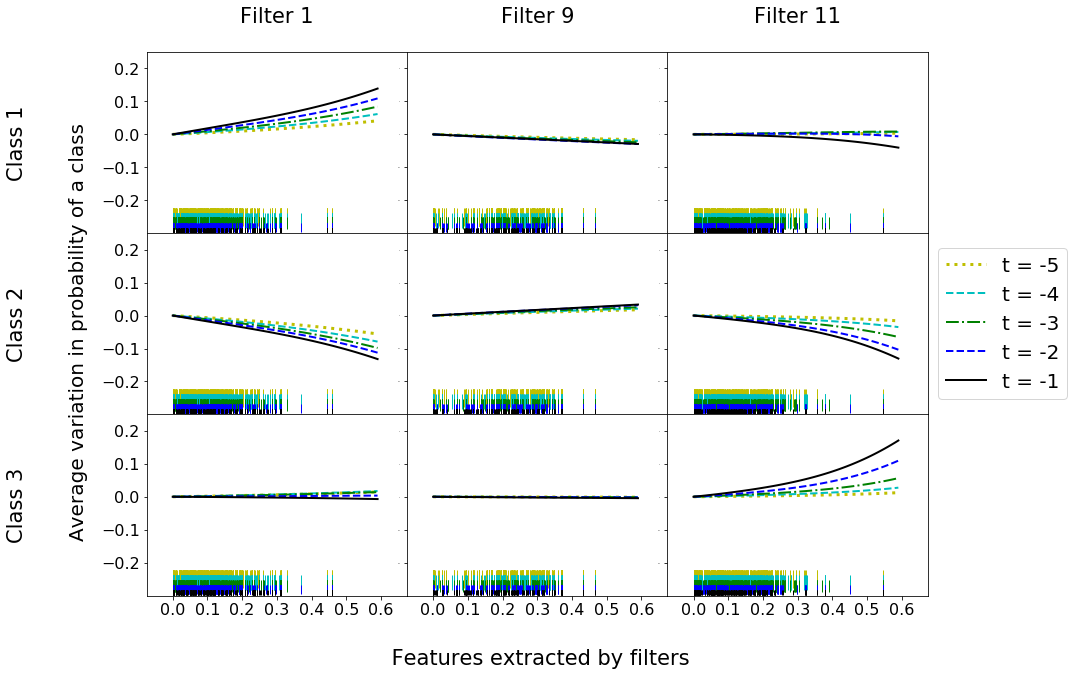

In [51]:
plt.figure(figsize=(14,10))
title=True
xaxis=False
xtick=False
legend=False
cont=0

for target in [1,2,3]: #kernels
    
    if cont>0: title=False
    #if cont==2: xaxis=True
    if cont==2: xtick=True
    
    plt.subplot(3, 3, 1+3*cont)
    #target=1
    kernel=1-1
    pdp_plot2(kernel,target,legend=legend, title=title, xaxis=xaxis, yaxis=True, xtick=xtick, ytick=True)
    
    
    if cont==2: xaxis=True
    plt.subplot(3, 3, 2+3*cont)
    #target=2
    kernel=9-1
    pdp_plot2(kernel,target,legend=legend, title=title, xaxis=xaxis, yaxis=False, xtick=xtick, ytick=False)
    xaxis=False
    
    if cont==1: legend=True
    plt.subplot(3, 3, 3+3*cont)
    #target=3
    kernel=11-1
    pdp_plot2(kernel,target,legend=legend, title=title, xaxis=xaxis, yaxis=False, xtick=xtick, ytick=False)

    legend=False
    
    
    cont+=1
 

plt.subplots_adjust(hspace=.0, wspace=.0)
plt.text(-1.8, 0.5, 'Average variation in probability of a class', va='center', rotation='vertical', size=20)

plt.savefig("plots/pdp_kernel.png", dpi=500,  bbox_inches='tight')

Plots for the supplementary material

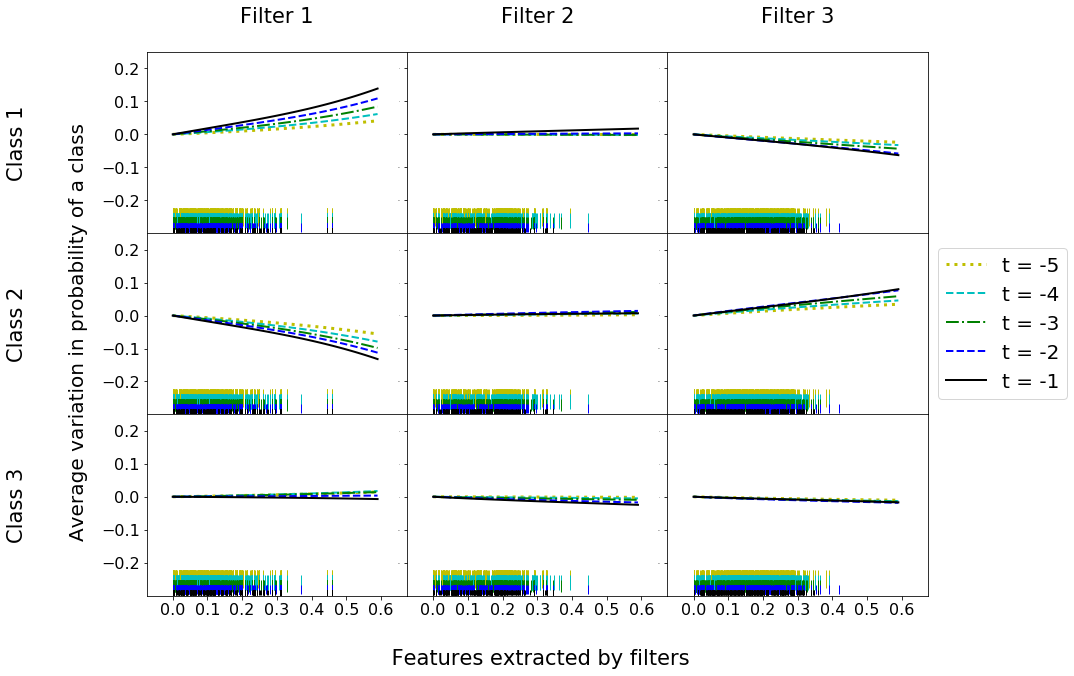

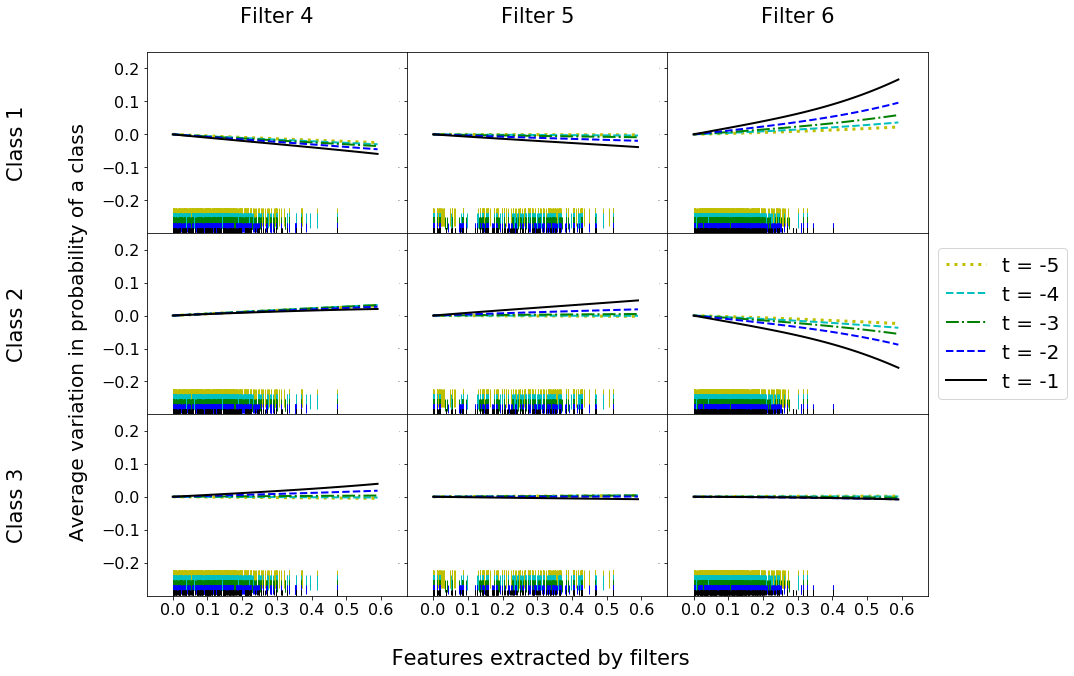

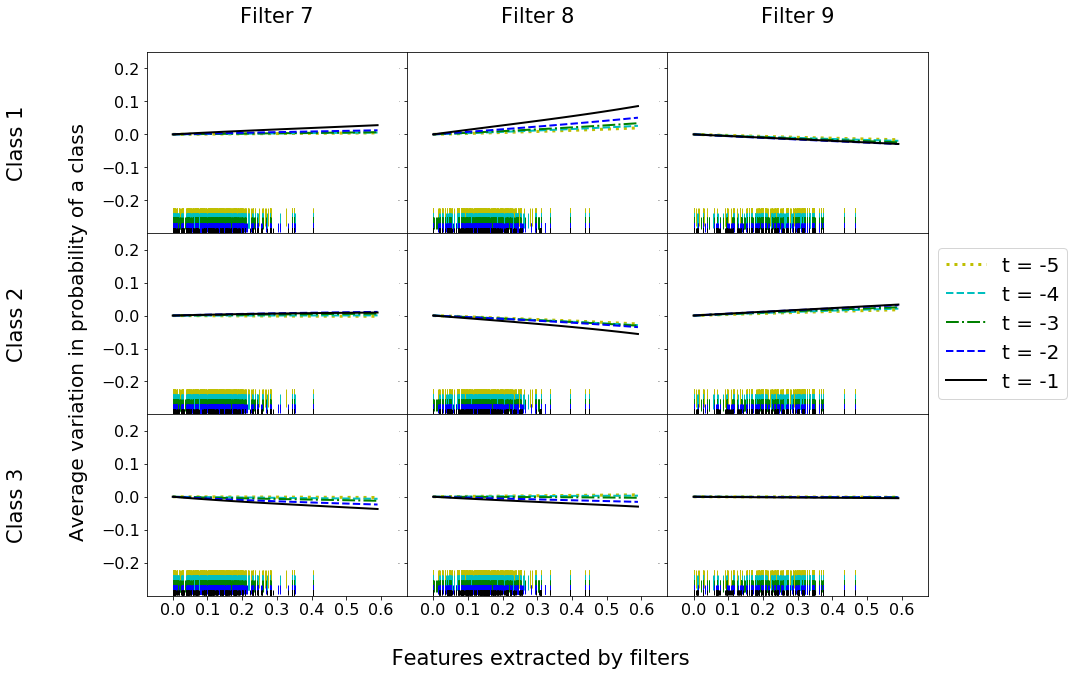

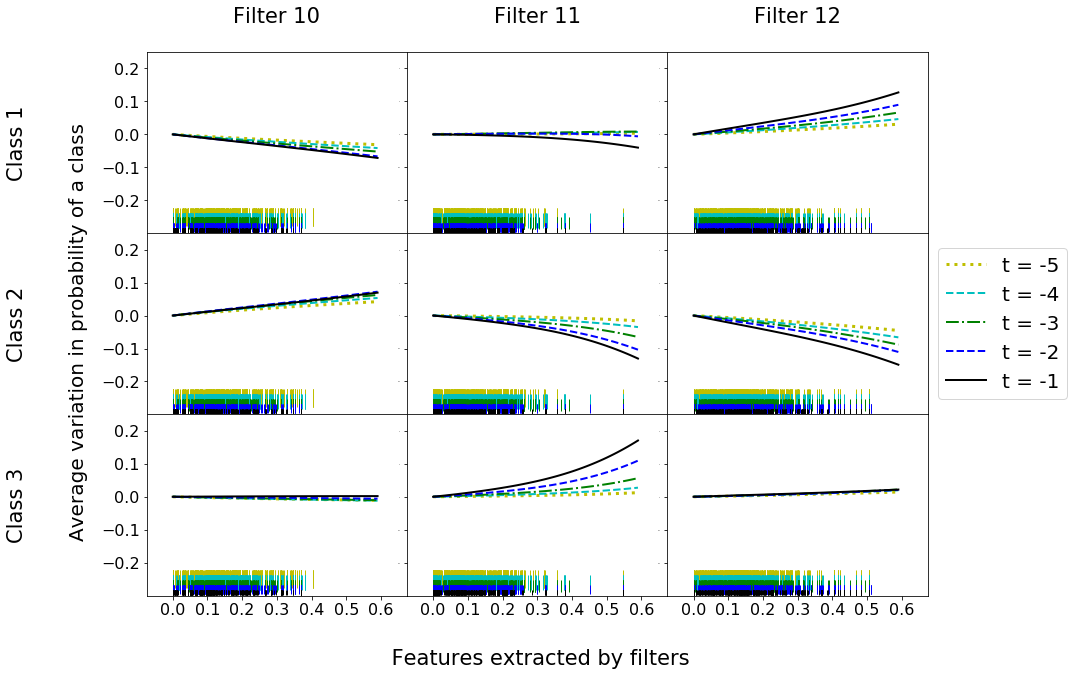

In [42]:
for i in range(4):
    
    plt.figure(figsize=(14,10))
    title=True
    xaxis=False
    xtick=False
    legend=False
    cont=0

    for target in [1,2,3]: #kernels

        if cont>0: title=False
        #if cont==2: xaxis=True
        if cont==2: xtick=True

        plt.subplot(3, 3, 1+3*cont)
        #target=1
        kernel=0+3*i
        pdp_plot2(kernel,target,legend=legend, title=title, xaxis=xaxis, yaxis=True, xtick=xtick, ytick=True)


        if cont==2: xaxis=True
        plt.subplot(3, 3, 2+3*cont)
        #target=2
        kernel=1+3*i
        pdp_plot2(kernel,target,legend=legend, title=title, xaxis=xaxis, yaxis=False, xtick=xtick, ytick=False)
        xaxis=False

        if cont==1: legend=True
        plt.subplot(3, 3, 3+3*cont)
        #target=3
        kernel=2+3*i
        pdp_plot2(kernel,target,legend=legend, title=title, xaxis=xaxis, yaxis=False, xtick=xtick, ytick=False)

        legend=False


        cont+=1


    plt.subplots_adjust(hspace=.0, wspace=.0)
    plt.text(-1.8, 0.5, 'Average variation in probability of a class', va='center', rotation='vertical', size=20)

    plt.savefig("plots/pdp_kernel"+str(i)+".png", dpi=100,  bbox_inches='tight')

# Performance benchmarks

### Doc2Vec

Doc2Vec model

In [49]:
doc = Doc2Vec.load("modelos/doc2vec_mov_100_5_V5")  

Function to embed the texts

In [ ]:
def emb_doc(tokens, model, normalize=True): #a opção normalize pode melhorar a qualidade do embedding
    
    model.random.seed(42)
    x=model.infer_vector(tokens, steps=20)
    
    if normalize: return(x/(np.sqrt(x@x)))
    else: return(x)

Function to get the X and y matrices

In [51]:
def get_X_y_doc(mov,tags,len1=5):
    
    #len1: let's take the last l1 motions in each proceeding
    
    #indexes of valid legal proceedings (with motions and tags)
    index=[]
    for i in range(len(mov)):
        if 0<len(mov[i]) and tags[i]!="": index.append(i) 
        else: pass

    print("Number of valid proceedings (with motions and tags):",len(index),"\n")

    #organizing motions in X and tags in y
    X=np.zeros((len(index),len1,embed_dim))
    y=[]
    cont=0
    
    #get numerical X embedding the tokens from those motions (from valid proceedings):
    for i in index:
        temp=[]
        y.append(tags[i])

        mov[i]=mov[i][-len1::] #let's take the last l1 motions in each proceeding

        for j in range(len(mov[i])):
            temp=emb_doc(tokenize(mov[i][j][1]), doc)
            X[cont][j][:np.shape(temp)[0]]=temp

        #counter
        cont+=1
        if cont%int(len(index)/5)==0: print(round(100*cont/len(index),0),"% concluded")
        else: pass
        
    return X,y

Getting the matrices

In [52]:
len1=5 #vamos pegar somente as últimas l1 movimentações

X,y=get_X_y_doc(mov,tags,len1)

Number of valid proceedings (with motions and tags): 6449 

20.0 % concluded
40.0 % concluded
60.0 % concluded
80.0 % concluded
100.0 % concluded


Encoding y

In [53]:
encode={'H:Arquivado': 1,'H:Ativo': 2,'H:Suspenso': 3}
decode={1:'H:Arquivado',2:'H:Ativo',3:'H:Suspenso'}
#
for i in range(len(y)):
    y[i]=encode[y[i]]

Splitting the data

In [54]:
y=np.array(y)
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=2/3, random_state=22)
#
y_train2=np.array(pd.get_dummies(y_train))
y_val2=np.array(pd.get_dummies(y_val))
y_test2=np.array(pd.get_dummies(y_test))

np.shape(X_train),np.shape(y_train)

((4514, 5, 100), (4514,))

Training ANN

In [55]:
keras.backend.clear_session()
random.seed(9)
np.random.seed(9)
tf.set_random_seed(9)

Adam=keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, amsgrad=False)

neuron=30
lamb=.0

### model for features extraction
inputs = Input(shape=np.shape(X_train)[1:]) 
time_layer = TimeDistributed(Lambda(lambda x: x))(inputs) 
lstm = LSTM(neuron, kernel_regularizer=l1(lamb))(time_layer)
soft = Dense(num_classes, activation='softmax')(lstm)

### final model
model_doc = Model(inputs, soft)

#compiling
model_doc.compile(loss='categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
model_doc.summary()

#fitting
modelo=model_doc.fit(X_train, y_train2, epochs=50,
                                    batch_size=500,
                                    shuffle=True,
                                    verbose=False,
                                    validation_data=(X_val, y_val2))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 100)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                15720     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 93        
Total params: 15,813
Trainable params: 15,813
Non-trainable params: 0
_________________________________________________________________


Plot training history

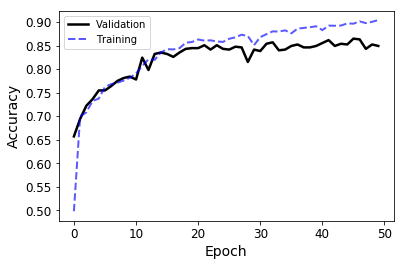

In [56]:
#Plotando dados de treino
plt.plot(modelo.history['val_accuracy'], 'k-', linewidth=2.5)
plt.plot(modelo.history['accuracy'],'b--', linewidth=2, alpha=.65)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(['Validation', 'Training'], loc='upper left')
plt.gcf().subplots_adjust(bottom=0.15)
plt.show()

Accuracy

In [57]:
#Accuracy
probs_y=model_doc.predict(X_test)
y_pred=np.argmax(probs_y,axis=1)
y_real=np.argmax(y_test2,axis=1)
p=np.mean(y_pred==y_real)

dict_acc['doc']=[np.round(p,2), np.round(1.96*np.sqrt((p*(1-p)/np.shape(y_pred)[0])),2)]


print("Accuracy test set=%3.2f" % p ,"+-", np.round(1.96*np.sqrt((p*(1-p)/np.shape(y_pred)[0])),2), "\n")

Accuracy test set=0.85 +- 0.02 



Storing other metrics

In [58]:
conf=confusion_matrix(y_pred,y_real)
report=classification_report(y_real, y_pred, labels=[0, 1, 2], output_dict=True)

dict_class_doc, dict_agg_doc=CI(report,conf)

### TFIDF

Tokenizer for tfidf

In [59]:
#Tokenizador de textos
stop_words = set(stopwords.words('portuguese'))

def tokenize_tfidf(txt):
    texto=txt
    texto=texto.split(' ') 
    texto=bibigrams[bigrams[texto]]
    tokens=[]
    for t in texto:
        if t not in stop_words: tokens.append(t)
        else: pass
 
    return(tokens)

TFIDF model

In [60]:
tfidf = pickle.load(open('modelos/tfidf_mov_V1.sav', 'rb'))
tfidf_dim=2000

Function to get the X and y matrices

In [61]:
def get_X_y_tfidf(mov,tags,len1=5):
    
    #len1: let's take the last l1 motions in each proceeding

    #indexes of valid legal proceedings (with motions and tags)
    index=[]
    for i in range(len(mov)):
        if 0<len(mov[i]) and tags[i]!="": index.append(i) 
        else: pass

    print("Number of valid proceedings (with motions and tags):",len(index),"\n")

    #organizing motions in X and tags in y
    X=np.zeros((len(index),len1,tfidf_dim))
    y=[]
    cont=0
    
    #get numerical X embedding the tokens from those motions (from valid proceedings):
    for i in index:
        temp=[]
        y.append(tags[i])

        mov[i]=mov[i][-len1::] #let's take the last l1 motions in each proceeding

        for j in range(len(mov[i])):
            temp=tfidf.transform([mov[i][j][1]]).toarray()[0]
            X[cont][j][:np.shape(temp)[0]]=temp

        #counter
        cont+=1
        if cont%int(len(index)/5)==0: print(round(100*cont/len(index),0),"% concluded")
        else: pass
        
    return X,y

Getting the X and y matrices

In [62]:
len1=5 #vamos pegar somente as últimas l1 movimentações

X,y=get_X_y_tfidf(mov,tags,len1)

Number of valid proceedings (with motions and tags): 6449 

20.0 % concluded
40.0 % concluded
60.0 % concluded
80.0 % concluded
100.0 % concluded


Encoding y

In [63]:
encode={'H:Arquivado': 1,'H:Ativo': 2,'H:Suspenso': 3}
decode={1:'H:Arquivado',2:'H:Ativo',3:'H:Suspenso'}
#
for i in range(len(y)):
    y[i]=encode[y[i]]

Splitting the data

In [64]:
y=np.array(y)
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=2/3, random_state=22)
#
y_train2=np.array(pd.get_dummies(y_train))
y_val2=np.array(pd.get_dummies(y_val))
y_test2=np.array(pd.get_dummies(y_test))

np.shape(X_train),np.shape(y_train)

((4514, 5, 2000), (4514,))

Training ANN

In [65]:
keras.backend.clear_session()
random.seed(9)
np.random.seed(9)
tf.set_random_seed(9)

Adam=keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, amsgrad=False)

neuron=30
lamb=0.0016

### model for features extraction
inputs = Input(shape=np.shape(X_train)[1:]) 
time_layer = TimeDistributed(Lambda(lambda x: x))(inputs) 
lstm = LSTM(neuron, kernel_regularizer=l1(lamb))(time_layer)
soft = Dense(num_classes, activation='softmax')(lstm)

### final model
model_tfidf = Model(inputs, soft)

#compiling
model_tfidf.compile(loss='categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
model_tfidf.summary()

#fitting
modelo=model_tfidf.fit(X_train, y_train2, epochs=50,
                                    batch_size=500,
                                    shuffle=True,
                                    verbose=False,
                                    validation_data=(X_val, y_val2))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 2000)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 2000)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                243720    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 93        
Total params: 243,813
Trainable params: 243,813
Non-trainable params: 0
_________________________________________________________________


Traning history

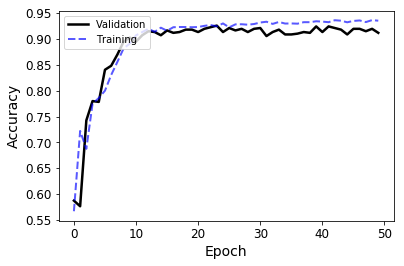

In [66]:
#Plotando dados de treino
plt.plot(modelo.history['val_accuracy'], 'k-', linewidth=2.5)
plt.plot(modelo.history['accuracy'],'b--', linewidth=2, alpha=.65)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(['Validation', 'Training'], loc='upper left')
plt.gcf().subplots_adjust(bottom=0.15)
plt.show()

Accuracy

In [67]:
#Accuracy
probs_y=model_tfidf.predict(X_test)
y_pred=np.argmax(probs_y,axis=1)
y_real=np.argmax(y_test2,axis=1)
p=np.mean(y_pred==y_real)

dict_acc['tfidf']=[np.round(p,2), np.round(1.96*np.sqrt((p*(1-p)/np.shape(y_pred)[0])),2)]

print("Accuracy test set=%3.2f" % p ,"+-", np.round(1.96*np.sqrt((p*(1-p)/np.shape(y_pred)[0])),2), "\n")

Accuracy test set=0.92 +- 0.02 



Storing other metrics

In [68]:
conf=confusion_matrix(y_pred,y_real)
report=classification_report(y_real, y_pred, labels=[0, 1, 2], output_dict=True)

dict_class_tfidf, dict_agg_tfidf=CI(report,conf)

### Latex tables

Comparing models

In [69]:
print("\\begin{table}[H] \n",
      "\centering \n",
      '\caption{Evaluation metrics by class} \n',
      ' \\begin{tabular}{c|c} \n',
      ' \\toprule \n',
      ' Feature extraction & Accuracy \\\ \n',
      ' \midrule \n',
      ' CNN &'+str(dict_acc['cnn'][0])+' \pm '+str(dict_acc['cnn'][1])+'\\\ \n',
      ' Doc2Vec &'+str(dict_acc['doc'][0])+' \pm '+str(dict_acc['doc'][1])+'\\\ \n',
      ' TFIDF  &'+str(dict_acc['tfidf'][0])+' \pm '+str(dict_acc['tfidf'][1])+'\\\ \n',
      ' \\bottomrule \n',
      ' \end{tabular}% \n',
      '\label{tab:lab}% \n',
   '\end{table}% \n')

\begin{table}[H] 
 \centering 
 \caption{Evaluation metrics by class} 
  \begin{tabular}{c|c} 
  \toprule 
  Feature extraction & Accuracy \\ 
  \midrule 
  CNN &0.93 \pm 0.01\\ 
  Doc2Vec &0.85 \pm 0.02\\ 
  TFIDF  &0.92 \pm 0.02\\ 
  \bottomrule 
  \end{tabular}% 
 \label{tab:lab}% 
 \end{table}% 



In [70]:
print("\\begin{table}[H] \n",
      "\centering \n",
      '\caption{Aggregate analysis of evaluation metrics} \n',
      ' \\begin{tabular}{c|ccc|ccc|c} \n',
      ' \\hline \n',
      '\multicolumn{1}{c}{} & \multicolumn{3}{c}{Macro averaging} & \multicolumn{3}{c}{Micro averaging} & \multicolumn{1}{c}{} \\\ \n',
      '\\hline \n',
      ' Feature extraction & F1 Score & Precision & Recall & F1 Score & Precision & Recall \\\ \n',
      ' \hline \n',
      ' CNN &'+str(dict_agg_cnn['macro']['f1'][0])+' \pm '+str(dict_agg_cnn['macro']['f1'][1])+'&'+str(dict_agg_cnn['macro']['prec'][0])+' \pm '+str(dict_agg_cnn['macro']['prec'][1])+'&'+str(dict_agg_cnn['macro']['rec'][0])+' \pm '+str(dict_agg_cnn['macro']['rec'][1])+'&'+str(dict_agg_cnn['micro']['f1'][0])+' \pm '+str(dict_agg_cnn['micro']['f1'][1])+'&'+str(dict_agg_cnn['micro']['prec'][0])+' \pm '+str(dict_agg_cnn['micro']['prec'][1])+'&'+str(dict_agg_cnn['micro']['rec'][0])+' \pm '+str(dict_agg_cnn['micro']['rec'][1])+'&'+'\\\ \n',
      ' Doc2Vec &'+str(dict_agg_doc['macro']['f1'][0])+' \pm '+str(dict_agg_doc['macro']['f1'][1])+'&'+str(dict_agg_doc['macro']['prec'][0])+' \pm '+str(dict_agg_doc['macro']['prec'][1])+'&'+str(dict_agg_doc['macro']['rec'][0])+' \pm '+str(dict_agg_doc['macro']['rec'][1])+'&'+str(dict_agg_doc['micro']['f1'][0])+' \pm '+str(dict_agg_doc['micro']['f1'][1])+'&'+str(dict_agg_doc['micro']['prec'][0])+' \pm '+str(dict_agg_doc['micro']['prec'][1])+'&'+str(dict_agg_doc['micro']['rec'][0])+' \pm '+str(dict_agg_doc['micro']['rec'][1])+'&'+'\\\ \n',
      ' TFIDF &'+str(dict_agg_tfidf['macro']['f1'][0])+' \pm '+str(dict_agg_tfidf['macro']['f1'][1])+'&'+str(dict_agg_tfidf['macro']['prec'][0])+' \pm '+str(dict_agg_tfidf['macro']['prec'][1])+'&'+str(dict_agg_tfidf['macro']['rec'][0])+' \pm '+str(dict_agg_tfidf['macro']['rec'][1])+'&'+str(dict_agg_tfidf['micro']['f1'][0])+' \pm '+str(dict_agg_tfidf['micro']['f1'][1])+'&'+str(dict_agg_tfidf['micro']['prec'][0])+' \pm '+str(dict_agg_tfidf['micro']['prec'][1])+'&'+str(dict_agg_tfidf['micro']['rec'][0])+' \pm '+str(dict_agg_tfidf['micro']['rec'][1])+'&'+'\\\ \n',
      ' \\hline \n',
      ' \end{tabular}% \n',
      '\label{tab:lab}% \n',
   '\end{table}% \n')

\begin{table}[H] 
 \centering 
 \caption{Aggregate analysis of evaluation metrics} 
  \begin{tabular}{c|ccc|ccc|c} 
  \hline 
 \multicolumn{1}{c}{} & \multicolumn{3}{c}{Macro averaging} & \multicolumn{3}{c}{Micro averaging} & \multicolumn{1}{c}{} \\ 
 \hline 
  Feature extraction & F1 Score & Precision & Recall & F1 Score & Precision & Recall \\ 
  \hline 
  CNN &0.89 \pm 0.02&0.92 \pm 0.02&0.87 \pm 0.03&0.93 \pm 0.01&0.93 \pm 0.01&0.93 \pm 0.01&\\ 
  Doc2Vec &0.82 \pm 0.03&0.85 \pm 0.03&0.8 \pm 0.03&0.85 \pm 0.01&0.86 \pm 0.02&0.85 \pm 0.02&\\ 
  TFIDF &0.88 \pm 0.02&0.93 \pm 0.02&0.85 \pm 0.03&0.91 \pm 0.01&0.92 \pm 0.01&0.92 \pm 0.02&\\ 
  \hline 
  \end{tabular}% 
 \label{tab:lab}% 
 \end{table}% 

